**Displays statistics for the use of default methods and parameters**

In [55]:
# include matplotlib widget
%matplotlib widget

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot, plot
from upsetplot import UpSet
from upsetplot import plot
from upsetplot import from_contents
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from collections import defaultdict

# Run this line if you are in a Jupyter Notebook environment
init_notebook_mode(connected=True)

# define paths for data and output
paths = {"base": "C://Users//avonl//OneDrive//Work//Research//projects//2023 - FRESH//code//FRESH//", 
         "alex": "alex//", 
         "data": "data//", 
         "tempfigs": "figs//",
         "finalfigs": "figures//alex_current//" 
        }

**load CSV file and clean data**

In [56]:
# loads csv to pandas dataframe
df = pd.read_csv(paths["base"]+paths["data"]+"FreshData_defaults.csv", encoding='utf-16', delimiter='\t')

# loads complete dataset csv to df_temp
df_temp = pd.read_csv(paths["base"]+paths["data"]+"FreshData.csv", encoding='utf-16', delimiter='\t')
# appends columns 'Analysis Confidence' and 'Results Confidence' from df_temp to df
df['Analysis Confidence'] = df_temp['Analysis Confidence']
df['Results Confidence'] = df_temp['Results confidence']

# unifies NaNs: Replace all "NaN" values in df with "nan"
df = df.replace(np.nan, 'nan', regex=True)

# delete all rows from df that contain 'false' in the column 'Investigated'
df_stat = df[df['Investigated']]

# rename 'Motion Artifact Correction Parameters' to 'Artifact Correction Param.'
df_stat = df_stat.rename(columns={'Motion Artifact Correction Parameters': 'Artifact Corr. Param.'})
# rename 'Quality/Pruning Parameters' to 'Pruning Param.'
df_stat = df_stat.rename(columns={'Quality/Pruning Parameters': 'Pruning Param.'})
# rename 'Filter Parameters' to 'Filter Param.'
df_stat = df_stat.rename(columns={'Filter Parameters': 'Filter Param.'})

**Analysis and visualization**

C:\Users\avonl\AppData\Local\Temp\ipykernel_15244\4135377916.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\avonl\AppData\Local\Temp\ipykernel_15244\4135377916.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning:

invalid value encountered in reduce

c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning:

invalid value encountered in reduce



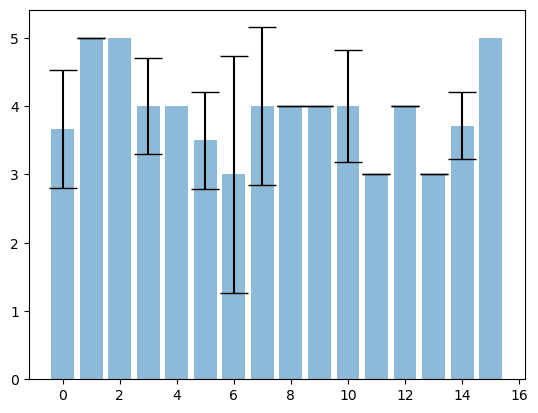

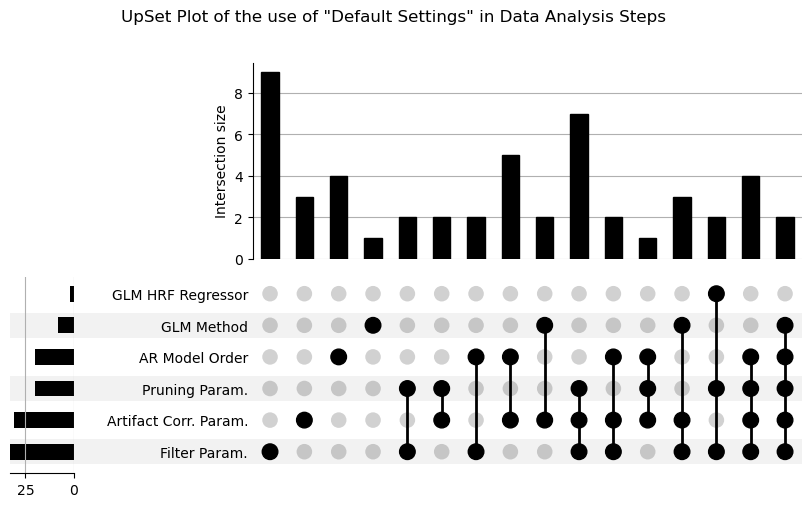

In [57]:
# extract confidence data
df_conf = df_stat[['Analysis Confidence', 'Results Confidence']]
# ensure data is numeric
df_conf['Analysis Confidence'] = pd.to_numeric(df_conf['Analysis Confidence'], errors='coerce')
df_conf['Results Confidence'] = pd.to_numeric(df_conf['Results Confidence'], errors='coerce')

# drop unnecessary columns for upset plot
df_stat = df_stat.drop(['Unnamed: 0', 'Study', 'ID', 'Investigated', 'Analysis Confidence', 'Results Confidence'], axis=1)

# Ensure all data is boolean
df_stat = df_stat.astype(bool)

# create a dictionary where each key is a column name and the value is a list of indices where the column is True
contents = {col: df_stat.index[df_stat[col]].tolist() for col in df_stat.columns}
# Generate an UpSet plot data
upset_data = from_contents(contents)

## identify all unique combinations of keys that actually occur in the data, akin to what from_contents does
# Reverse mapping: index to list of keys
index_to_keys = defaultdict(list)
for key, indices in contents.items():
    for index in indices:
        index_to_keys[index].append(key)
# Collect unique sets of keys
unique_combinations = set()
for keys in index_to_keys.values():
    # Convert list to a tuple so it can be added to a set
    combination = tuple(sorted(keys))  # Sorting ensures that duplicates are not created due to order
    unique_combinations.add(combination)

# Dictionary to store indices for each combination
combination_indices = {}
# Iterate through each combination and filter the DataFrame
for combination in unique_combinations:
    # Create a mask for the specified columns to be True
    mask_true = df_stat[list(combination)].all(axis=1)
    
    # Create a mask for all other columns to be False
    other_columns = df_stat.columns.difference(combination)
    mask_false = ~df_stat[list(other_columns)].any(axis=1)
    # Combine both masks
    final_mask = mask_true & mask_false
    # Get the indices of the rows matching the mask
    matching_indices = df_stat[final_mask].index.tolist()
    # Store the indices in the dictionary
    combination_indices[combination] = matching_indices


# for all combinations calculate the mean and std analysis confidence and results confidence from df_conf
# initializes list to store mean and std results and analysis confidences for each combination
mean_std_conf = []
# iterates through each combination
for combination in unique_combinations:
    # creates a list of indices for each combination
    matching_indices = combination_indices[combination]
    # creates a dataframe of confidences for each combination
    df_conf_temp = df_conf.loc[matching_indices]
    # calculates the mean and std of analysis confidence for each combination
    mean_analysis_conf = df_conf_temp['Analysis Confidence'].mean()
    std_analysis_conf = df_conf_temp['Analysis Confidence'].std()
    # calculates the mean and std of results confidence for each combination
    mean_results_conf = df_conf_temp['Results Confidence'].mean()
    std_results_conf = df_conf_temp['Results Confidence'].std()
    # appends the mean and std of analysis and results confidence to the list
    mean_std_conf.append([mean_analysis_conf, std_analysis_conf, mean_results_conf, std_results_conf])
# rename the columns of mean_std_conf to "Mean Analysis Confidence", "Std Analysis Confidence", "Mean Results Confidence", "Std Results Confidence"
mean_std_conf = pd.DataFrame(mean_std_conf, columns=["Mean Analysis Confidence", "Std Analysis Confidence", "Mean Results Confidence", "Std Results Confidence"])


# Plot
plot(upset_data)
plt.suptitle('UpSet Plot of the use of "Default Settings" in Data Analysis Steps')
# save the plot
plt.savefig(paths["base"]+paths["alex"]+paths["tempfigs"]+"upsetplot_defaults.png")
# show
plt.show()


**Create Barplots**

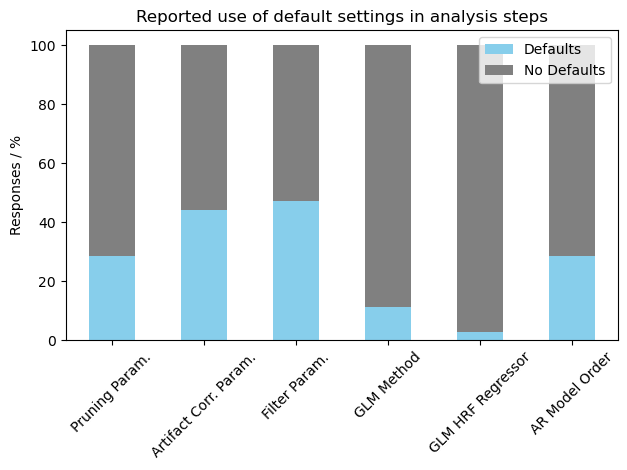

In [58]:
# Count the number of True values in each column
true_counts = df_stat.sum()

# Proportions of True and False values
true_proportions = df_stat.mean()*100
false_proportions = (1 - df_stat.mean())*100

# Set up the bar plot
true_proportions.plot(kind='bar', color='skyblue', label='Defaults')
false_proportions.plot(kind='bar', color='grey', bottom=true_proportions, label='No Defaults')

# Adding labels and title
plt.title('Reported use of default settings in analysis steps')
plt.ylabel('Responses / %')
plt.xticks(rotation=45)
plt.legend()

# save the plot
plt.tight_layout()  # Adjust layout
plt.savefig(paths["base"]+paths["alex"]+paths["tempfigs"]+"barplot_defaults.png")
# Show the plot
plt.show()
